In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

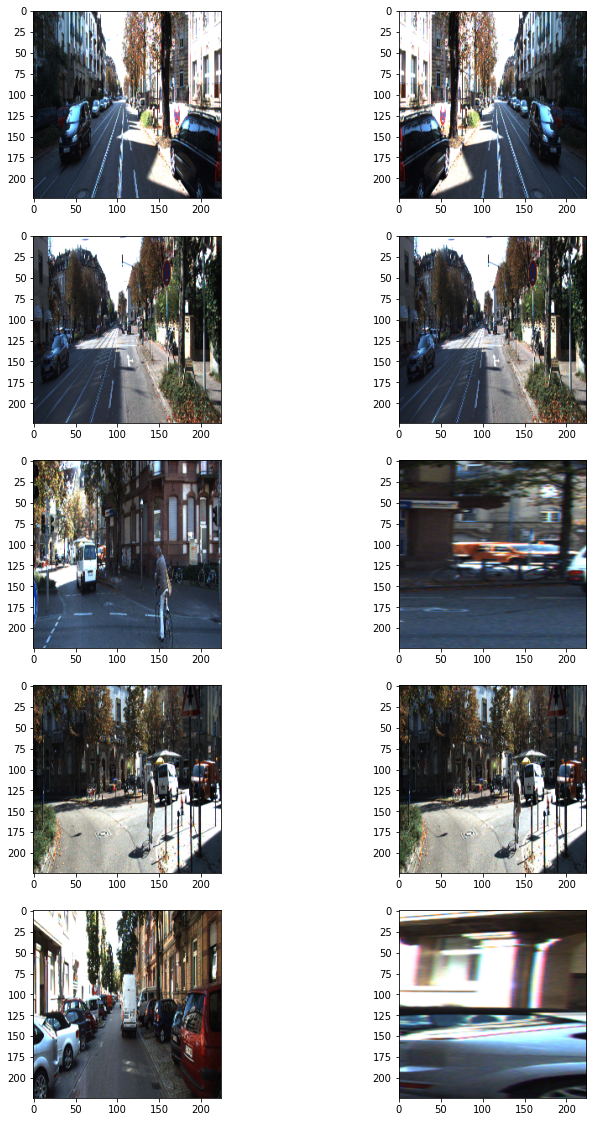

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [32]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
    return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [33]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [21]:
def conv_block(x, filters):
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    return x

def build_model(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = conv_block(p4, 1024)

    # Decoder
    u1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn)
    u1 = concatenate([u1, c4])
    c5 = conv_block(u1, 512)

    u2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c3])
    c6 = conv_block(u2, 256)

    u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c2])
    c7 = conv_block(u3, 128)

    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u4 = concatenate([u4, c1])
    c8 = conv_block(u4, 64)

    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs, outputs)
    return model
def conv_block(x, filters):
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    return x

def build_model(input_shape=(224, 224, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    bn = conv_block(p4, 1024)

    # Decoder
    u1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn)
    u1 = concatenate([u1, c4])
    c5 = conv_block(u1, 512)

    u2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c3])
    c6 = conv_block(u2, 256)

    u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c2])
    c7 = conv_block(u3, 128)

    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u4 = concatenate([u4, c1])
    c8 = conv_block(u4, 64)

    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c8)

    model = Model(inputs, outputs)
    return model


In [40]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model.h5'

model_unet = build_model()
model_unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model_unet.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_unet.save(model_path) 

Epoch 1/100
43/43 [==============================] - 21s 416ms/step - loss: 0.6246 - val_loss: 0.5609
Epoch 2/100
43/43 [==============================] - 10s 234ms/step - loss: 0.4084 - val_loss: 0.3421
Epoch 3/100
43/43 [==============================] - 10s 236ms/step - loss: 0.2773 - val_loss: 0.2816
Epoch 4/100
43/43 [==============================] - 10s 240ms/step - loss: 0.2412 - val_loss: 0.3430
Epoch 5/100
43/43 [==============================] - 11s 246ms/step - loss: 0.2234 - val_loss: 0.2241
Epoch 6/100
43/43 [==============================] - 13s 295ms/step - loss: 0.2038 - val_loss: 0.2306
Epoch 7/100
43/43 [==============================] - 15s 337ms/step - loss: 0.2073 - val_loss: 0.2443
Epoch 8/100
43/43 [==============================] - 11s 243ms/step - loss: 0.1968 - val_loss: 0.2208
Epoch 9/100
43/43 [==============================] - 11s 242ms/step - loss: 0.2041 - val_loss: 0.2357
Epoch 10/100
43/43 [==============================] - 11s 243ms/step - loss: 0.183

In [19]:
# model = tf.keras.models.load_model(model_path)

In [22]:
def calculate_iou_score(target, prediction):
    target = target.astype(bool)
    prediction = prediction.astype(bool)

    # 1. 교집합
    intersection = np.logical_and(target, prediction).sum()

    # 2. 합집합
    union = np.logical_or(target, prediction).sum()

    # 3. IoU 계산 (0으로 나누는 경우 방지)
    iou_score = float(intersection) / float(union) if union != 0 else 1.0

    print('IoU : %f' % iou_score)
    return iou_score

In [19]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

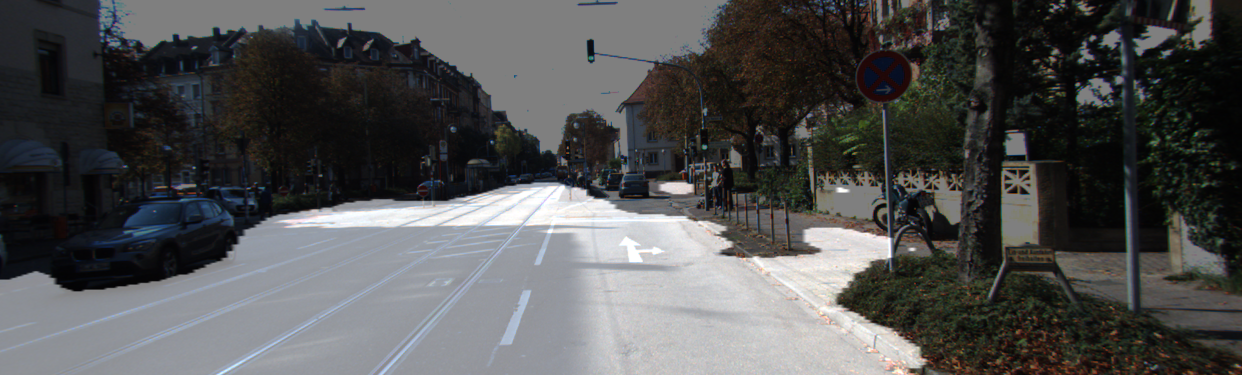

IoU : 0.886406


0.8864058260745394

In [41]:

i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

In [20]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


# Dice 계수 계산 함수 (픽셀 단위 유사도 측정)
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Flatten: 픽셀을 1차원 배열로 변환
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    # 교집합 계산
    intersection = K.sum(y_true_f * y_pred_f)

    # Dice 계수 공식
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


# Dice 기반 손실 함수 (Loss = 1 - Dice)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


# 업샘플링 블록 (두 가지 중 택 1)

def up_block(x, filters, method='transpose'):
    if method == 'transpose':
        # Conv2DTranspose 방식 (학습 가능한 업샘플링)
        x = Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')(x)
    elif method == 'upsample':
        # UpSampling2D + Conv2D 방식 (가볍고 빠름)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(filters, kernel_size=2, padding='same', activation='relu')(x)
    return x



# U-Net++ 모델 정의 함수

def build_unet_plus_plus(input_shape=(224, 224, 3), num_classes=1, upsampling='transpose'):
    inputs = Input(input_shape)

    # Encoder 경로 (Backbone)
    x00 = conv_block(inputs, 64)                          # Level 0
    x10 = conv_block(MaxPooling2D(2)(x00), 128)           # Level 1
    x20 = conv_block(MaxPooling2D(2)(x10), 256)           # Level 2
    x30 = conv_block(MaxPooling2D(2)(x20), 512)           # Level 3
    x40 = conv_block(MaxPooling2D(2)(x30), 1024)          # Level 4 (bottleneck)

    # Decoder + Nested Skip Connections
    # X^0_1
    x01 = conv_block(concatenate([
        x00,
        up_block(x10, 64, upsampling)
    ]), 64)

    # X^1_1
    x11 = conv_block(concatenate([
        x10,
        up_block(x20, 128, upsampling)
    ]), 128)

    # X^2_1
    x21 = conv_block(concatenate([
        x20,
        up_block(x30, 256, upsampling)
    ]), 256)

    # X^3_1
    x31 = conv_block(concatenate([
        x30,
        up_block(x40, 512, upsampling)
    ]), 512)

    # X^0_2
    x02 = conv_block(concatenate([
        x00,
        x01,
        up_block(x11, 64, upsampling)
    ]), 64)

    # X^1_2
    x12 = conv_block(concatenate([
        x10,
        x11,
        up_block(x21, 128, upsampling)
    ]), 128)

    # X^0_3
    x03 = conv_block(concatenate([
        x00,
        x01,
        x02,
        up_block(x12, 64, upsampling)
    ]), 64)

    # 최종 출력 계층 
    outputs = Conv2D(num_classes, kernel_size=1, activation='sigmoid')(x03)

    # 모델 정의
    model = Model(inputs, outputs)
    return model


In [36]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_unet_plus_plus()
model.compile(optimizer = Adam(1e-4), loss = dice_loss)
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 22s 310ms/step - loss: 0.6395 - val_loss: 0.6040
Epoch 2/100
43/43 [==============================] - 13s 308ms/step - loss: 0.5301 - val_loss: 0.4939
Epoch 3/100
43/43 [==============================] - 16s 375ms/step - loss: 0.4425 - val_loss: 0.4640
Epoch 4/100
43/43 [==============================] - 15s 352ms/step - loss: 0.3807 - val_loss: 0.3792
Epoch 5/100
43/43 [==============================] - 14s 326ms/step - loss: 0.3388 - val_loss: 0.4548
Epoch 6/100
43/43 [==============================] - 14s 320ms/step - loss: 0.3063 - val_loss: 0.3662
Epoch 7/100
43/43 [==============================] - 14s 322ms/step - loss: 0.2317 - val_loss: 0.3598
Epoch 8/100
43/43 [==============================] - 16s 370ms/step - loss: 0.2397 - val_loss: 0.3122
Epoch 9/100
43/43 [==============================] - 15s 340ms/step - loss: 0.2107 - val_loss: 0.2977
Epoch 10/100
43/43 [==============================] - 14s 313ms/step - loss: 0.223

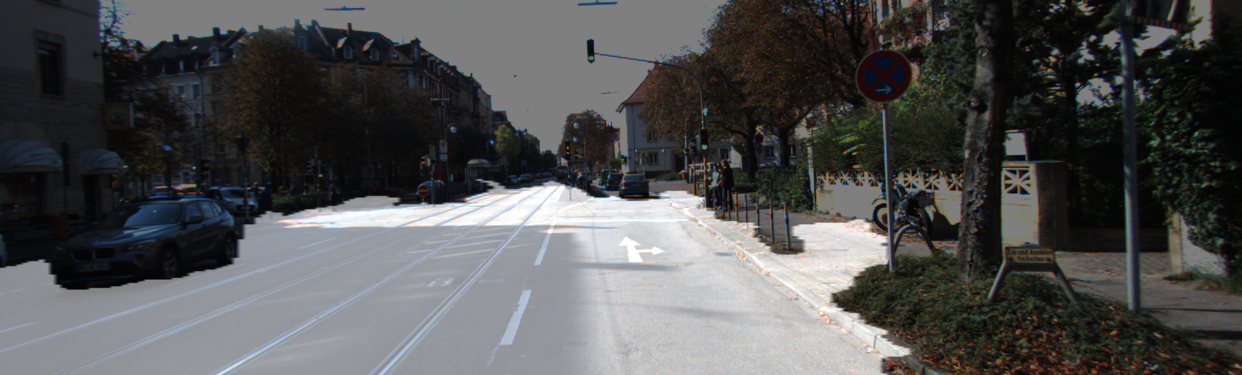

IoU : 0.883087


0.8830866807610994

In [39]:

i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

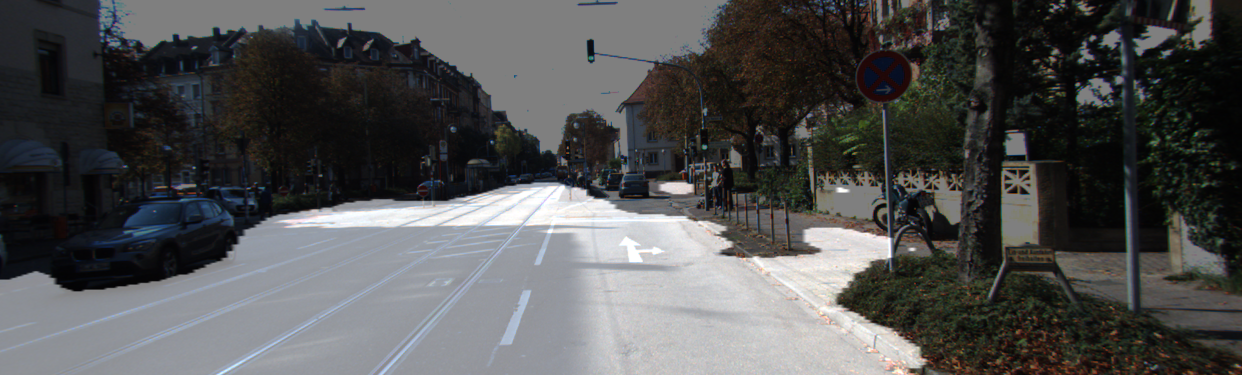

IoU : 0.886406


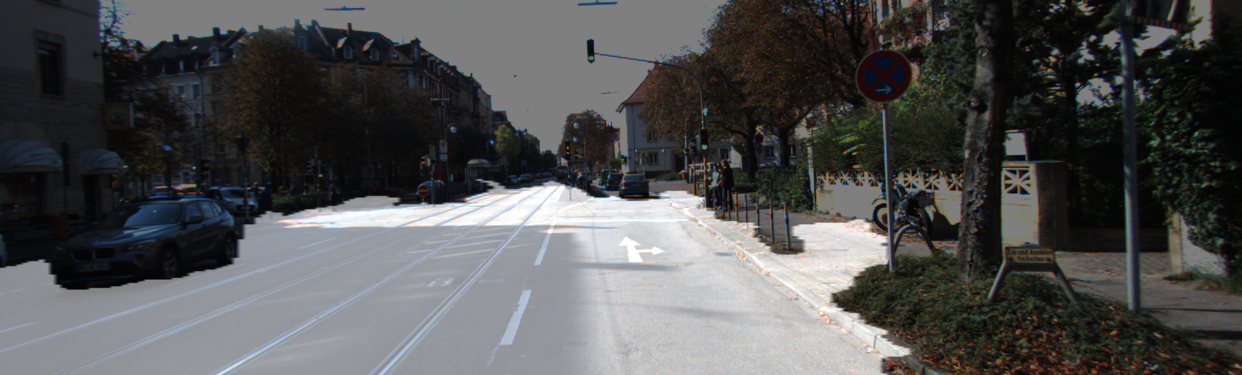

IoU : 0.883087
     Model  IoU Score
0    U-Net   0.886406
1  U-Net++   0.883087


In [42]:
import pandas as pd

# i 값 설정
i = 1

# U-Net 결과
output_unet, prediction_unet, target = get_output(
    model_unet,
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=dir_path + f'./result_unet_{str(i).zfill(3)}.png',
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)
iou_unet = calculate_iou_score(target, prediction_unet)

# U-Net++ 결과
output_unetpp, prediction_unetpp, _ = get_output(
    model,  # model == model_unetplusplus
    test_preproc,
    image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
    output_path=dir_path + f'./result_unetpp_{str(i).zfill(3)}.png',
    label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)
iou_unetpp = calculate_iou_score(target, prediction_unetpp)

# 결과 표 작성
iou_table = pd.DataFrame({
    'Model': ['U-Net', 'U-Net++'],
    'IoU Score': [iou_unet, iou_unetpp]
})

# 출력
print(iou_table)

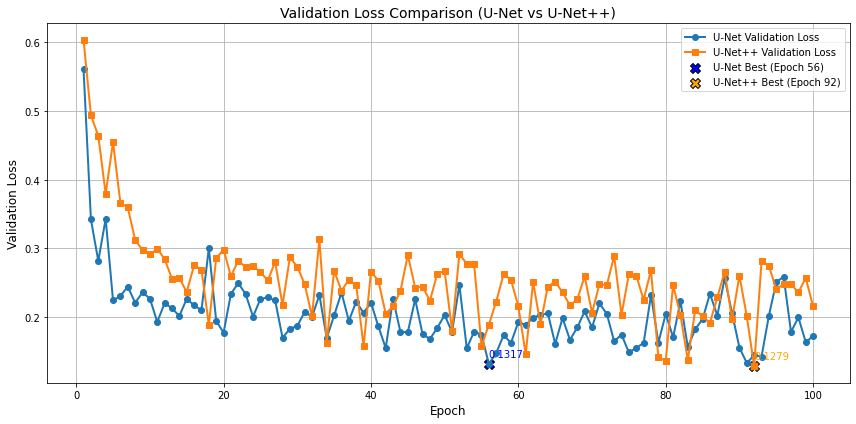

In [57]:
import matplotlib.pyplot as plt

# 1 ~ 100 에포크
epochs = list(range(1, 101))

# === U-Net Validation Loss 기록 ===
val_loss_unet = [
    0.5609, 0.3421, 0.2816, 0.3430, 0.2241, 0.2306, 0.2443, 0.2208, 0.2357, 0.2269,
    0.1928, 0.2201, 0.2127, 0.2015, 0.2265, 0.2169, 0.2098, 0.3002, 0.1943, 0.1771,
    0.2338, 0.2494, 0.2331, 0.2005, 0.2262, 0.2286, 0.2241, 0.1698, 0.1827, 0.1870,
    0.2071, 0.2001, 0.2321, 0.1692, 0.2022, 0.2355, 0.1945, 0.2221, 0.2060, 0.2211,
    0.1864, 0.1547, 0.2262, 0.1781, 0.1781, 0.2257, 0.1752, 0.1679, 0.1841, 0.2030,
    0.1778, 0.2469, 0.1544, 0.1787, 0.1743, 0.1317, 0.1474, 0.1736, 0.1623, 0.1926,
    0.1884, 0.1991, 0.2027, 0.2055, 0.1608, 0.1985, 0.1667, 0.1848, 0.2081, 0.1847,
    0.2198, 0.2047, 0.1646, 0.1743, 0.1483, 0.1550, 0.1621, 0.2319, 0.1625, 0.2044,
    0.1705, 0.2227, 0.1560, 0.1821, 0.1971, 0.2338, 0.2020, 0.2566, 0.2055, 0.1554,
    0.1329, 0.1443, 0.1423, 0.2020, 0.2510, 0.2585, 0.1782, 0.1994, 0.1633, 0.1723
]

# === U-Net++ Validation Loss 기록 ===
val_loss_unetpp = [
    0.6040, 0.4939, 0.4640, 0.3792, 0.4548, 0.3662, 0.3598, 0.3122, 0.2977, 0.2912,
    0.2993, 0.2844, 0.2556, 0.2566, 0.2364, 0.2753, 0.2689, 0.1886, 0.2856, 0.2982,
    0.2594, 0.2822, 0.2723, 0.2743, 0.2652, 0.2533, 0.2802, 0.2174, 0.2869, 0.2733,
    0.2480, 0.2009, 0.3132, 0.1628, 0.2674, 0.2381, 0.2545, 0.2459, 0.1577, 0.2657,
    0.2531, 0.2049, 0.2154, 0.2378, 0.2902, 0.2427, 0.2441, 0.2237, 0.2630, 0.2670,
    0.1802, 0.2923, 0.2771, 0.2771, 0.1577, 0.1887, 0.2225, 0.2624, 0.2540, 0.2156,
    0.1457, 0.2509, 0.1898, 0.2443, 0.2514, 0.2359, 0.2168, 0.2257, 0.2592, 0.2058,
    0.2481, 0.2459, 0.2890, 0.2030, 0.2625, 0.2601, 0.2251, 0.2682, 0.1410, 0.1362,
    0.2463, 0.2025, 0.1373, 0.2103, 0.2008, 0.1915, 0.2285, 0.2660, 0.1966, 0.2604,
    0.2008, 0.1279, 0.2809, 0.2743, 0.2404, 0.2482, 0.2476, 0.2359, 0.2569, 0.2153
]

best_epoch_unet = np.argmin(val_loss_unet) + 1
best_val_unet = val_loss_unet[best_epoch_unet - 1]

best_epoch_unetpp = np.argmin(val_loss_unetpp) + 1
best_val_unetpp = val_loss_unetpp[best_epoch_unetpp - 1]

plt.figure(figsize=(12, 6))
plt.plot(epochs, val_loss_unet, label='U-Net Validation Loss', marker='o', linewidth=2)
plt.plot(epochs, val_loss_unetpp, label='U-Net++ Validation Loss', marker='s', linewidth=2)

plt.scatter(best_epoch_unet, best_val_unet, color='blue', s=100, marker='X', edgecolors='black', label=f'U-Net Best (Epoch {best_epoch_unet})')
plt.scatter(best_epoch_unetpp, best_val_unetpp, color='orange', s=100, marker='X', edgecolors='black', label=f'U-Net++ Best (Epoch {best_epoch_unetpp})')

plt.text(best_epoch_unet, best_val_unet + 0.01, f'{best_val_unet:.4f}', color='blue', fontsize=10)
plt.text(best_epoch_unetpp, best_val_unetpp + 0.01, f'{best_val_unetpp:.4f}', color='orange', fontsize=10)

plt.title('Validation Loss Comparison (U-Net vs U-Net++)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## IOU가 unet++가 더 낮은 이유
- 학습 가장 마지막 결과를 기준으로 weight 가 설정되어 계산이 되기 때문에 정확하게 반영되지 않았다.
- best 지점의 에포크를 기준으로 IOU를 다시 구하면 더 정확하게 반영가능하다.

In [47]:
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint

# 저장 경로 설정
model_dir = os.path.join(os.getenv('HOME'), 'aiffel/semantic_segmentation')
os.makedirs(model_dir, exist_ok=True)

# 모델 저장 경로
final_model_path = os.path.join(model_dir, 'seg_model_unet_last.h5')
best_model_path = os.path.join(model_dir, 'seg_model_unet_best.h5')
history_path = os.path.join(model_dir, 'seg_model_unet_history.pkl')

# 체크포인트 설정
checkpoint = ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
    mode='min'
)

# 모델 구성
model_unet = build_model()
model_unet.compile(optimizer=Adam(1e-4), loss=dice_loss)

# 모델 학습
history = model_unet.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    callbacks=[checkpoint]
)

# 마지막 모델 저장
model_unet.save(final_model_path)

# 학습 기록 저장 (history.history는 dict)
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/100
43/43 [==============================] - 16s 355ms/step - loss: 0.6784 - val_loss: 0.6255

Epoch 00001: val_loss improved from inf to 0.62553, saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet_best.h5
Epoch 2/100
43/43 [==============================] - 12s 283ms/step - loss: 0.4484 - val_loss: 0.3471

Epoch 00002: val_loss improved from 0.62553 to 0.34709, saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet_best.h5
Epoch 3/100
43/43 [==============================] - 11s 245ms/step - loss: 0.3699 - val_loss: 0.3102

Epoch 00003: val_loss improved from 0.34709 to 0.31019, saving model to /aiffel/aiffel/semantic_segmentation/seg_model_unet_best.h5
Epoch 4/100
43/43 [==============================] - 14s 320ms/step - loss: 0.3594 - val_loss: 0.3530

Epoch 00004: val_loss did not improve from 0.31019
Epoch 5/100
43/43 [==============================] - 11s 263ms/step - loss: 0.3586 - val_loss: 0.3441

Epoch 00005: val_loss did not improve from

In [48]:

# 모델 저장 경로
final_model_path_pp = os.path.join(model_dir, 'seg_model_unetpp_last.h5')
best_model_path_pp = os.path.join(model_dir, 'seg_model_unetpp_best.h5')
history_path_pp = os.path.join(model_dir, 'seg_model_unetpp_history.pkl')

# 체크포인트 설정
checkpoint_pp = ModelCheckpoint(
    filepath=best_model_path_pp,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1,
    mode='min'
)

# 모델 구성
model_unet_pp = build_unet_plus_plus()
model_unet_pp.compile(optimizer=Adam(1e-4), loss=dice_loss)

# 모델 학습
history_pp = model_unet_pp.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    callbacks=[checkpoint]
)

# 마지막 모델 저장
model_unet_pp.save(final_model_path)

# 학습 기록 저장 (history.history는 dict)
with open(history_path_pp, 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/100
43/43 [==============================] - 19s 422ms/step - loss: 0.6634 - val_loss: 0.6169

Epoch 00001: val_loss did not improve from 0.28510
Epoch 2/100
43/43 [==============================] - 14s 313ms/step - loss: 0.5365 - val_loss: 0.3957

Epoch 00002: val_loss did not improve from 0.28510
Epoch 3/100
43/43 [==============================] - 14s 329ms/step - loss: 0.3669 - val_loss: 0.3780

Epoch 00003: val_loss did not improve from 0.28510
Epoch 4/100
43/43 [==============================] - 14s 332ms/step - loss: 0.2612 - val_loss: 0.3049

Epoch 00004: val_loss did not improve from 0.28510
Epoch 5/100
43/43 [==============================] - 15s 338ms/step - loss: 0.2574 - val_loss: 0.3120

Epoch 00005: val_loss did not improve from 0.28510
Epoch 6/100
43/43 [==============================] - 16s 362ms/step - loss: 0.2621 - val_loss: 0.2867

Epoch 00006: val_loss did not improve from 0.28510
Epoch 7/100
43/43 [==============================] - 13s 308ms/step - loss: 

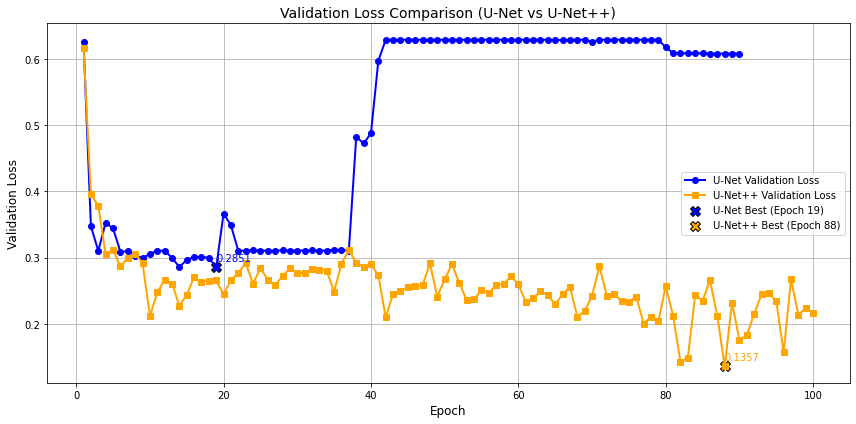

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# === U-Net val_loss 리스트 (로그에서 추출한 값) ===
val_loss_unet = [
    0.6255, 0.3471, 0.3102, 0.3530, 0.3441, 0.3091, 0.3094, 0.3032, 0.2997, 0.3054,
    0.3107, 0.3104, 0.2998, 0.2857, 0.2967, 0.3009, 0.3012, 0.2996, 0.2851, 0.3665,
    0.3487, 0.3103, 0.3106, 0.3112, 0.3106, 0.3104, 0.3107, 0.3109, 0.3106, 0.3107,
    0.3107, 0.3108, 0.3106, 0.3107, 0.3120, 0.3115, 0.3106, 0.4823, 0.4724, 0.4875,
    0.5972, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289,
    0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289,
    0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6283, 0.6289, 0.6289, 0.6288, 0.6258,
    0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6289, 0.6174,
    0.6088, 0.6085, 0.6085, 0.6085, 0.6084, 0.6080, 0.6080, 0.6080, 0.6080, 0.6080
]

# === U-Net++ val_loss 리스트 (로그에서 추출한 값) ===
val_loss_unetpp = [
    0.6169, 0.3957, 0.3780, 0.3049, 0.3120, 0.2867, 0.2997, 0.3053, 0.2925, 0.2118,
    0.2475, 0.2660, 0.2609, 0.2275, 0.2435, 0.2706, 0.2627, 0.2651, 0.2655, 0.2446,
    0.2663, 0.2765, 0.2920, 0.2607, 0.2839, 0.2666, 0.2587, 0.2717, 0.2842, 0.2773,
    0.2762, 0.2824, 0.2815, 0.2799, 0.2488, 0.2907, 0.3117, 0.2918, 0.2858, 0.2900,
    0.2733, 0.2098, 0.2448, 0.2497, 0.2551, 0.2565, 0.2584, 0.2912, 0.2412, 0.2674,
    0.2898, 0.2610, 0.2356, 0.2373, 0.2512, 0.2468, 0.2586, 0.2599, 0.2718, 0.2599,
    0.2331, 0.2384, 0.2493, 0.2430, 0.2293, 0.2450, 0.2553, 0.2109, 0.2191, 0.2424,
    0.2866, 0.2428, 0.2456, 0.2340, 0.2332, 0.2412, 0.2005, 0.2109, 0.2037, 0.2569,
    0.2126, 0.1425, 0.1491, 0.2434, 0.2351, 0.2660, 0.2123, 0.1357, 0.2322, 0.1752,
    0.1830, 0.2147, 0.2446, 0.2460, 0.2343, 0.1569, 0.2670, 0.2139, 0.2237, 0.2166
]

# === Epochs (각 val_loss 길이에 맞춰 생성) ===
epochs_unet = list(range(1, len(val_loss_unet) + 1))
epochs_unetpp = list(range(1, len(val_loss_unetpp) + 1))

# === Best Epoch 및 Loss 계산 ===
best_epoch_unet = np.argmin(val_loss_unet) + 1
best_val_unet = val_loss_unet[best_epoch_unet - 1]

best_epoch_unetpp = np.argmin(val_loss_unetpp) + 1
best_val_unetpp = val_loss_unetpp[best_epoch_unetpp - 1]

# === 시각화 ===
plt.figure(figsize=(12, 6))

plt.plot(epochs_unet, val_loss_unet, label='U-Net Validation Loss', color='blue', marker='o', linewidth=2)
plt.plot(epochs_unetpp, val_loss_unetpp, label='U-Net++ Validation Loss', color='orange', marker='s', linewidth=2)

# Best 포인트 강조
plt.scatter(best_epoch_unet, best_val_unet, color='blue', s=100, marker='X', edgecolors='black', label=f'U-Net Best (Epoch {best_epoch_unet})')
plt.scatter(best_epoch_unetpp, best_val_unetpp, color='orange', s=100, marker='X', edgecolors='black', label=f'U-Net++ Best (Epoch {best_epoch_unetpp})')

# 텍스트 주석
plt.text(best_epoch_unet, best_val_unet + 0.01, f'{best_val_unet:.4f}', color='blue', fontsize=10)
plt.text(best_epoch_unetpp, best_val_unetpp + 0.01, f'{best_val_unetpp:.4f}', color='orange', fontsize=10)

# 그래프 꾸미기
plt.title('Validation Loss Comparison (U-Net vs U-Net++)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 결과
- loss 기준을 동일하게 doce_loss 로 한 결과 unet++ 의 일반화 성능이 더 좋게 나왔다.
- IOU는 마지막 weight 기준에서 진행했을 때는 unet이 더 높게 나왔는데, best 지점에 대한 h5를 저장하는데 실패해서 best 지점에서의 IOU로 산출하지는 못했다.

## 회고
- 배운 점 : IOU 기준이 학습 마지막 weight 기준이어서, 최적의 epoch 결과 지점을 저장후 산출하면 정확한 iou 비교가 될 수 있다는 것을 배웠다.
- 아쉬운 점 : IOU 를 best 지점에서 구하는 것을 하지 못했다.